PRE PROCESSING

In [31]:
import librosa
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import pickle
import tensorflow as tf 

from tf_keras.utils import to_categorical
from tf_keras.models import Sequential, load_model
from tf_keras.layers import Dense, LSTM, Dropout

from sklearn.model_selection import train_test_split

In [32]:
def extract_features(file_name):
    try:
        # Memuat file audio
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        
        # Ekstraksi fitur MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # Mengambil rata-rata MFCC di sepanjang sumbu waktu
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        
        return mfccs_scaled
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        print(f"Error: {e}")
        return None

In [33]:
# Path utama ke folder data audio
main_dir = 'Dataset'  # Ganti dengan path yang sesuai jika berada di direktori yang berbeda
labels = []
features = []

# Melalui semua subfolder dan file audio
for subdir, dirs, files in os.walk(main_dir):
    for file in files:
        if file.endswith('.wav'):  # Menggunakan hanya file .wav
            file_path = os.path.join(subdir, file)
            
            # Mengekstrak fitur dari file audio
            mfccs = extract_features(file_path)
            
            # Menyimpan fitur dan label jika berhasil diekstrak
            if mfccs is not None:
                features.append(mfccs)
                
                # Mengambil label dari nama subfolder
                # Nama folder parent diambil sebagai label
                label = os.path.basename(subdir)
                labels.append(label)

# Mengubah list fitur dan label ke numpy array
X = np.array(features)
y = np.array(labels)

print(f"Extracted {len(X)} features and {len(y)} labels.")

# Encoding label menggunakan LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Menyimpan fitur dan label yang sudah diencode
with open('features.pkl', 'wb') as f:
    pickle.dump(X, f)
with open('labels.pkl', 'wb') as f:
    pickle.dump(y_encoded, f)

print("Preprocessing selesai. Data fitur dan label telah disimpan.")

Extracted 6229 features and 6229 labels.
Preprocessing selesai. Data fitur dan label telah disimpan.


In [34]:
# Menyimpan label encoder untuk digunakan nanti
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [35]:
# Memuat fitur dan label
with open('features.pkl', 'rb') as f:
    X = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    y_encoded = pickle.load(f)

# One-hot encoding untuk label
y_categorical = to_categorical(y_encoded)

# Memastikan bahwa bentuk data sesuai untuk CNN
X = np.expand_dims(X, axis=-1)  # Menambahkan dimensi untuk saluran (channel)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y_categorical.shape}")

Shape of X: (6229, 40, 1)
Shape of y: (6229, 84)


In [36]:
# Memuat data dari file pickle
with open('features.pkl', 'rb') as f:
    X = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    y = pickle.load(f)

# Memeriksa bentuk data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (6229, 40)
Shape of y: (6229,)


In [37]:
# Menyusun ulang dimensi jika diperlukan (menghapus dimensi terakhir jika hanya 1)
if X.ndim == 2:
    X = np.expand_dims(X, axis=-1)

# Mengonversi label menjadi one-hot encoding jika belum
num_classes = 84
if y.ndim == 1 or y.shape[1] != num_classes:
    y = to_categorical(y, num_classes=num_classes)

# Membagi data menjadi set pelatihan dan set validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Membangun model
model = Sequential()

# Menambahkan layer LSTM
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Mengompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih model
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_val, y_val))

# Menyimpan model
model.save('model.h5')

Epoch 1/20
156/156 [==============================] - 6s 21ms/step - loss: 4.4381 - accuracy: 0.0126 - val_loss: 4.4326 - val_accuracy: 0.0144
Epoch 2/20
156/156 [==============================] - 3s 17ms/step - loss: 4.3650 - accuracy: 0.0209 - val_loss: 4.2161 - val_accuracy: 0.0161
Epoch 3/20
156/156 [==============================] - 3s 17ms/step - loss: 4.1563 - accuracy: 0.0303 - val_loss: 4.0435 - val_accuracy: 0.0241
Epoch 4/20
156/156 [==============================] - 3s 17ms/step - loss: 4.0323 - accuracy: 0.0315 - val_loss: 3.9105 - val_accuracy: 0.0393
Epoch 5/20
156/156 [==============================] - 3s 18ms/step - loss: 3.8628 - accuracy: 0.0419 - val_loss: 3.7176 - val_accuracy: 0.0409
Epoch 6/20
156/156 [==============================] - 3s 17ms/step - loss: 3.6994 - accuracy: 0.0460 - val_loss: 3.5983 - val_accuracy: 0.0530
Epoch 7/20
156/156 [==============================] - 3s 18ms/step - loss: 3.6084 - accuracy: 0.0524 - val_loss: 3.4929 - val_accuracy: 0.0682

c:\Users\reinj\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


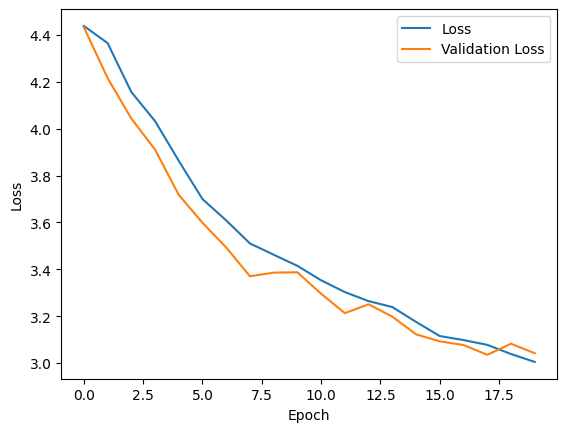

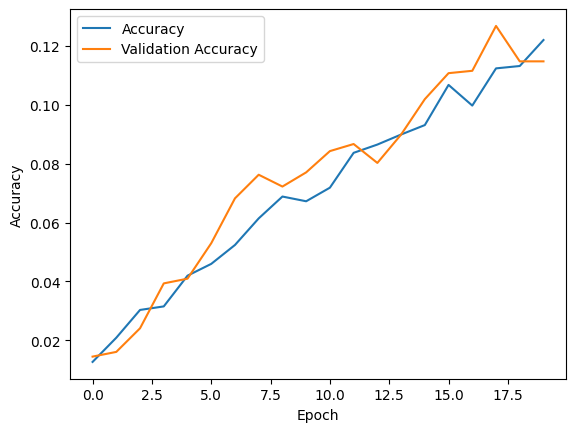

In [38]:
# Menampilkan hasil pelatihan
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
# Memuat model yang sudah dilatih
model = load_model('model.h5')

# Memuat data dari file pickle
with open('features.pkl', 'rb') as f:
    X = pickle.load(f)
with open('labels.pkl', 'rb') as f:
    y = pickle.load(f)

# Mengonversi label menjadi one-hot encoding jika belum
num_classes = 84
if y.ndim == 1 or y.shape[1] != num_classes:
    y = to_categorical(y, num_classes=num_classes)

# Membagi data menjadi set pelatihan dan set validasi
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Mengevaluasi model pada data validasi
eval_results = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {eval_results[0]}")
print(f"Validation Accuracy: {eval_results[1]}")

39/39 [==============================] - 1s 7ms/step - loss: 3.0420 - accuracy: 0.1148
Validation Loss: 3.0419650077819824
Validation Accuracy: 0.11476725339889526


In [40]:
# # Menggunakan model untuk prediksi pada data baru
# def preprocess_new_data(file_path):
#     """
#     Fungsi untuk memproses file audio baru menjadi fitur yang sesuai.
#     """
#     mfccs = extract_features(file_path)
#     if mfccs is not None:
#         mfccs = np.expand_dims(mfccs, axis=0)  # Menambahkan dimensi batch
#         return mfccs
#     return None

# # Contoh file audio baru untuk pengujian
# new_file_path = 'A.wav'  # Ganti dengan path file audio baru Anda
# new_data = preprocess_new_data(new_file_path)

# if new_data is not None:
#     predictions = model.predict(new_data)
#     predicted_class = np.argmax(predictions, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
#     print(f"Predicted class: {predicted_class}")
# else:
#     print("Failed to preprocess the new audio data.")

Error encountered while parsing file: A.wav
Error: [Errno 2] No such file or directory: 'A.wav'
Failed to preprocess the new audio data.


C:\Users\reinj\AppData\Local\Temp\ipykernel_19584\1763379335.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
c:\Users\reinj\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [43]:
# ... existing code ...

# Menggunakan model untuk prediksi pada data baru
def preprocess_new_data(file_path):
    """
    Fungsi untuk memproses file audio baru menjadi fitur yang sesuai.
    """
    mfccs = extract_features(file_path)
    if mfccs is not None:
        mfccs = np.expand_dims(mfccs, axis=0)  # Menambahkan dimensi batch
        return mfccs
    return None

# Folder yang berisi data baru untuk pengujian
new_data_folder = 'dataset_baru'

# Memuat label encoder
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Iterasi melalui semua file dalam folder dataset_baru
for file_name in os.listdir(new_data_folder):
    if file_name.endswith('.wav'):
        file_path = os.path.join(new_data_folder, file_name)
        new_data = preprocess_new_data(file_path)
        
        if new_data is not None:
            predictions = model.predict(new_data)[0]
            top_5_indices = np.argsort(predictions)[-5:][::-1]
            top_5_classes = le.inverse_transform(top_5_indices)
            top_5_confidences = predictions[top_5_indices] * 100
            
            print(f"File: {file_name}")
            print("Top 5 predictions:")
            for cls, conf in zip(top_5_classes, top_5_confidences):
                print(f"  {cls}: {conf:.2f}%")
            print("---")
        else:
            print(f"Failed to preprocess the audio file: {file_name}")
            print("---")

# ... existing code ...

1/1 [==============================] - 0s 14ms/step
File: A.wav
Top 5 predictions:
  15. jim_dommah: 9.32%
  84. ya_dommah: 8.74%
  33. zay_dommah: 6.57%
  69. lam_dommah: 5.70%
  24. dal_dommah: 4.95%
---
1/1 [==============================] - 0s 17ms/step
File: B.wav
Top 5 predictions:
  15. jim_dommah: 9.17%
  36. sin_dommah: 6.05%
  24. dal_dommah: 5.48%
  12. tsa_dommah: 5.36%
  27. dzal_dommah: 5.15%
---
1/1 [==============================] - 0s 16ms/step
File: BI.wav
Top 5 predictions:
  84. ya_dommah: 14.34%
  15. jim_dommah: 8.70%
  69. lam_dommah: 7.55%
  80. waw_kasroh: 7.34%
  33. zay_dommah: 6.47%
---
1/1 [==============================] - 0s 16ms/step
File: BU.wav
Top 5 predictions:
  84. ya_dommah: 13.51%
  15. jim_dommah: 8.44%
  80. waw_kasroh: 7.77%
  69. lam_dommah: 7.01%
  33. zay_dommah: 5.95%
---
1/1 [==============================] - 0s 16ms/step
File: C.wav
Top 5 predictions:
  15. jim_dommah: 8.71%
  84. ya_dommah: 6.27%
  33. zay_dommah: 5.64%
  24. dal_dommah